In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from collections import Counter
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# Introduction


* Aquiring Data and analyzing the dataset
* EDA - Exploratory data analysis


# Aquiring Data

We'll first read the csv(comma separated values) files into a training and testing dataframes which we can manipulate for analysis and predictions

In [ ]:
#Reading data in the .csv format (no special encoding schemes required)

df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
id_t = df_test['PassengerId']
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


**Outlier detection**

In [ ]:
#Outlier detection using the Tukey method

def detect(dataframe,n,features):
    ind = []
    for column in features:
        q1 = np.percentile(dataframe[column],25)
        q3 = np.percentile(dataframe[column],75)
        res = q3 - q1
        new = 1.5 * res
        out = dataframe[(dataframe[column]<q1 - new) | (dataframe[column] >q3 + new)].index
        ind.extend(out)
    ind = Counter(ind)
    val = list(s for s,i in ind.items() if i>n)
    return val

#Detecting outliers for the numerical features
ott = detect(df_train,2,["Age","SibSp","Parch","Fare"])

Outliers can have dramatic effects on our predictions and can also result in harming our final result. We find outliers for the numerical features in the given dataset and we outlined rows with atleast two outliers

In [ ]:
#Our final outliers - can have a harmful effect on regression tasks
df_train.loc[ott]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


These rows were identified as outliers according to our given function so we will proceed to drop them from our dataframe

In [ ]:
df_train.drop(ott,axis=0,inplace=True) #dropping on the row axis

Create a final dataset (used while feature tuning and cleaning) by combining the training and testing dataframe

In [ ]:
#Dataset combining both the training and testing datasets
t_len = len(df_train)
final = pd.concat([df_train,df_test],axis=0).reset_index(drop=True)
final.shape

(1299, 12)

# Analyzing the dataset

Viewing the first 5 rows of the dataset

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


List of columns present in the dataset

In [ ]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Checking for NULL values**

Multiple NULL values present in Age and Cabin while only 2 in the Embarked column.

In [ ]:
df_train.info()
df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 881 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 89.5+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
df_test.info()
df_test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The describe method provides us a brief summary of basic statistical measures such as quartiles, mean, count etc.

In [ ]:
#Brief statistics
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [ ]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# EDA (exploratory data analysis)

Checking the correlation among the numerical variables present in the dataset

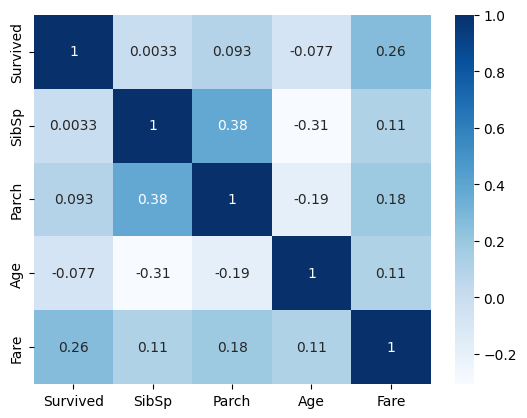

In [ ]:
#Correlation between numerical values

hm = sns.heatmap(df_train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,cmap='Blues')

We see that there's high correlation only between fare and survival probabilities, this feature may turn out to be our main focus

In [ ]:
df_train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Sex,Survived
0,female,0.747573
1,male,0.190559


There is a much higher probability of females surviving on the Titanic than men, Let us now proceed to visualize it.

Text(0.5, 0, 'Sex')

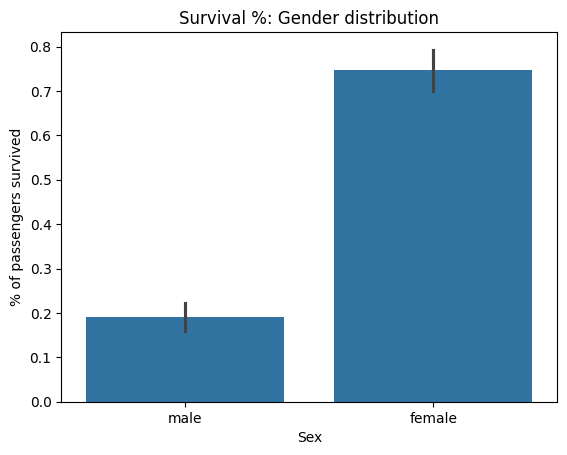

In [ ]:
#Plot for gender distribition of survival rate
sns.barplot(x='Sex',y='Survived',data=df_train)
plt.title('Survival %: Gender distribution')
plt.ylabel('% of passengers survived')
plt.xlabel('Sex')

We can clearly see that gender plays a huge role in calculating the survival probability for a passenger. This is a crucial feature that would help to improve upon our predictions.

We will now visualize the total passenger count according to gender and survivability.

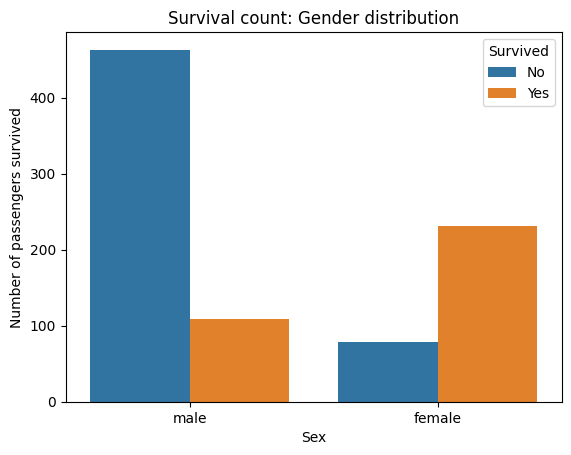

In [ ]:
#Survivor count for each gender
m = sns.countplot(x='Sex',hue='Survived',data=df_train)
plt.title('Survival count: Gender distribution')
plt.xlabel('Sex')
plt.ylabel('Number of passengers survived')
a = m.get_legend()
b = a.texts
b[0].set_text('No')
b[1].set_text('Yes')

Again, we see that there is a large difference between the number of survivors between both of the genders.

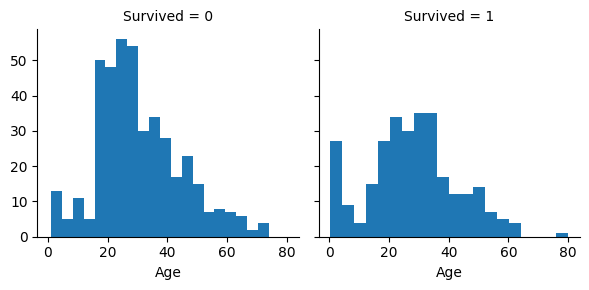

In [ ]:
#Age survival ratio
s = sns.FacetGrid(df_train,col='Survived')
s.map(plt.hist,'Age',bins=20)

It seems that the middle-aged and old people had a very low survival probability as compared to infants, childrens and young adults. Age plays an important role in saving yourself during a time of crisis.

Text(0.5, 0, 'Passenger class')

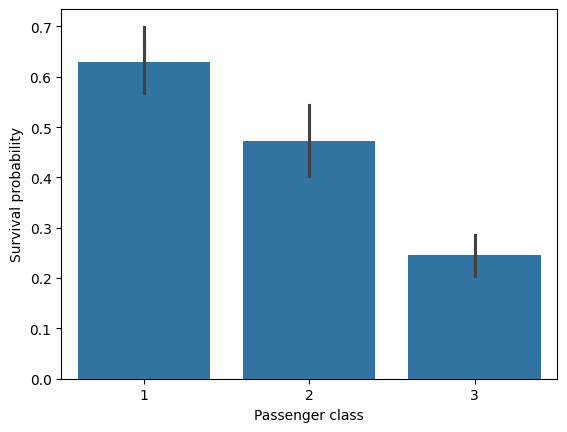

In [ ]:
#Survival probability vs Class
b = sns.barplot(x='Pclass',y='Survived',data=df_train)
b.set_ylabel('Survival probability')
b.set_xlabel('Passenger class')

Text(0.5, 0, 'Pclass')

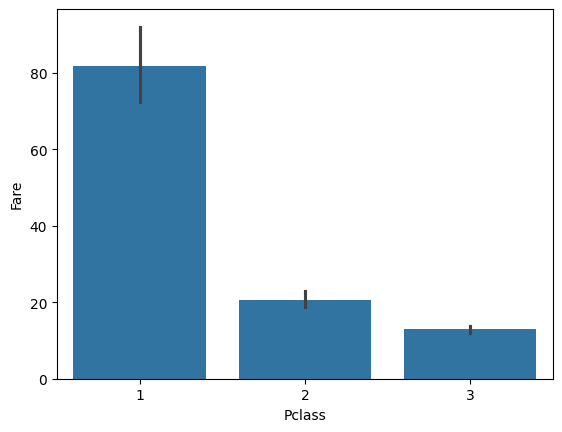

In [ ]:
c = sns.barplot(x='Pclass',y='Fare',data=df_train)
c.set_ylabel('Fare')
c.set_xlabel('Pclass')

It seems that the rich people present in Passenger Class 1 had a much higher probability of survival in comparison to the other passenger classes. The fare is proportional to the survivability result.

Text(0.5, 0, 'Passenger class')

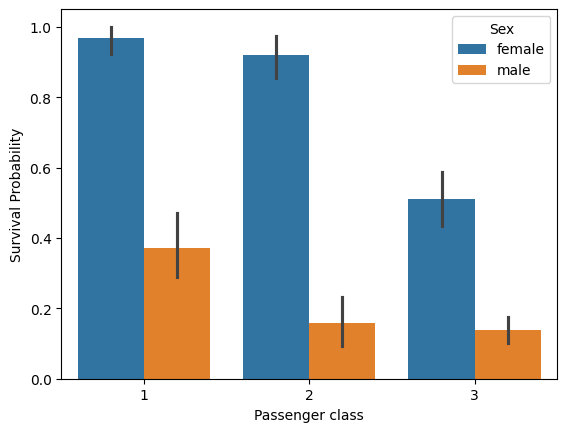

In [ ]:
#Survival Probability vs Class and Sex
b = sns.barplot(x='Pclass',y='Survived',hue='Sex',data=df_train)
b.set_ylabel('Survival Probability')
b.set_xlabel('Passenger class')

We observe a similar trend here where the survival probability is in direct correlation with the gender as well as the Passenger class. Higher the passenger class equalled low fare which results in low survival chance.

Text(0.5, 0, 'Embarked')

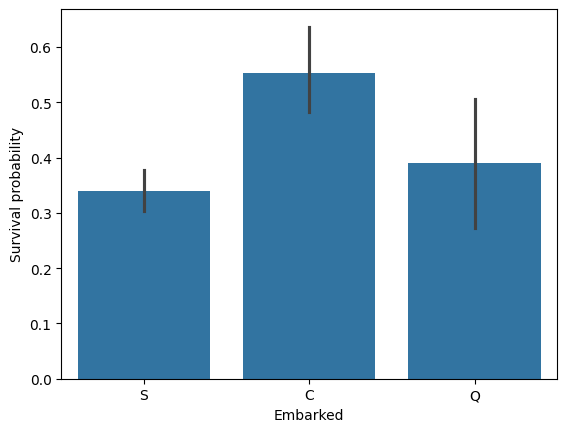

In [ ]:
#Exploring Embarked vs Survival probability
ax = sns.barplot(x='Embarked',y='Survived',data=df_train)
ax.set_ylabel('Survival probability')
ax.set_xlabel('Embarked')

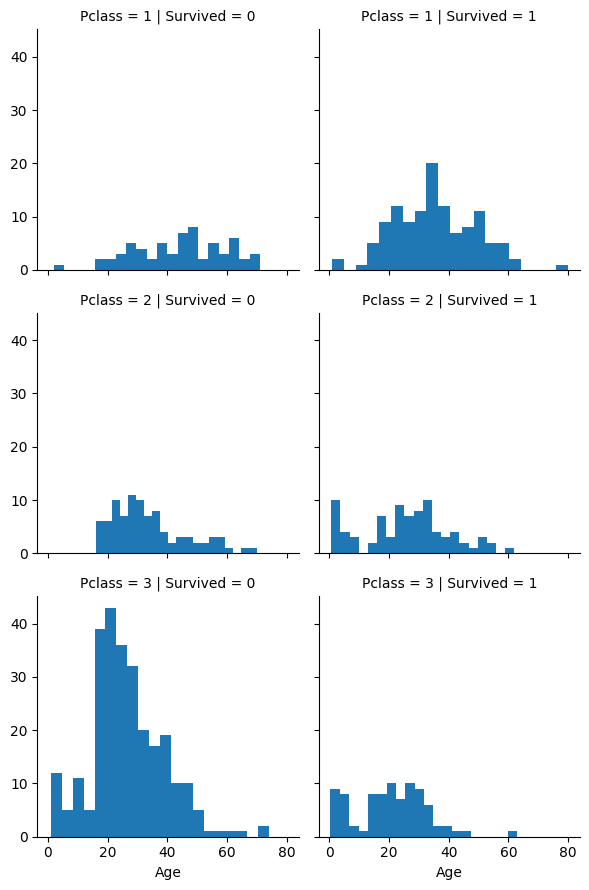

In [ ]:
g1 = sns.FacetGrid(df_train,col='Survived',row='Pclass')
g1.map(plt.hist,'Age',bins=20)

We see that Pclass 1 consists of more middle-aged and old men while P-class 2 and 3 consist of infants, children and the like. It is a similar occurence in real-life where usually old and rich people travel in First-Class with the presenece of children being very rare.

We also see that the survived histogram dwindles down in height as we move lower down the graph. The histogram still rises up pretty well for the lower age group which is what we saw above as well. Children, teenagers and young adults have a higher survival rate than the middle-aged and old people.

Text(0.5, 0, 'Fare distribution')

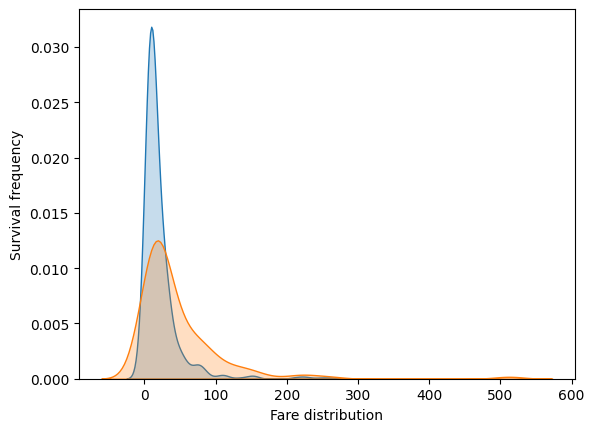

In [ ]:
#Fare distribution
a1 = sns.kdeplot(df_train.loc[(df_train['Survived']==0),'Fare'],shade=True,label='Not Survived')
a1 = sns.kdeplot(df_train.loc[(df_train['Survived']==1),'Fare'],shade=True,label='Survived')
plt.ylabel('Survival frequency')
plt.xlabel('Fare distribution')

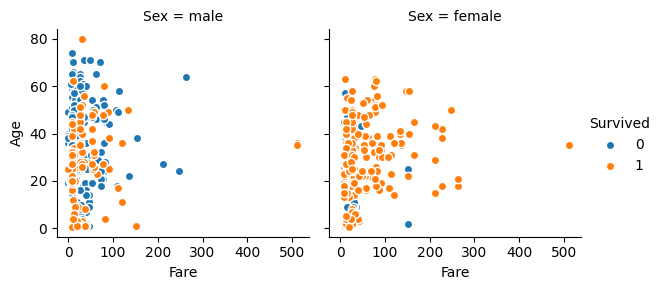

In [ ]:
#Survival by Fare,Age and Sex
s = sns.FacetGrid(df_train,hue='Survived',col='Sex')
s.map(plt.scatter,'Fare','Age',edgecolor='w').add_legend()

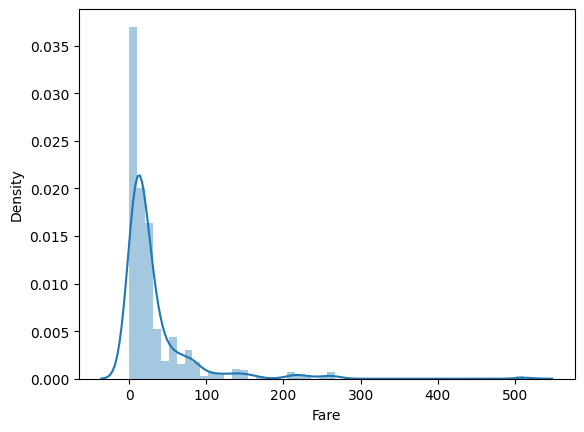

In [ ]:
#Plotting fare in the combined dataset
s = sns.distplot(final['Fare'])